In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph
import random

In [3]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0 # at initialization, we assume that every value does not effect the output
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value=({self.data})"
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # Chain rule with the derivative of tanh, where t is our tanh value
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self): # initialize backward function to be called on the final output node to iterate backwards through all children
        self.grad = 1.0
        topo = []
        visited = set()
        def buildTopo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    buildTopo(child)
                topo.append(v)
        
        buildTopo(self)
        
        for node in reversed(topo):
            node._backward()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if we receive a non-value attribute, convert it to value
        out = Value(self.data + other.data, (self, other), "+") # for every addition, feed in the children to the new value as well as the operation type

        def _backward():
            self.grad += 1.0 * out.grad # in an addition, out.grad is simply copied to the input/child nodes
            other.grad += 1.0 * out.grad # this is according to the chain rule
        out._backward = _backward # dont call the function!! this would return None. Only store the function reference, therefore no ()

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # if we receive a non-value attribute, convert it to value
        out = Value(self.data * other.data, (self, other), "*") # for every multiplication, feed in the children to the new value as well as the operation type

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __truediv__(self, other): # self / other
        return self * other**-1 # NOTE: For this to work, we need to implement the power function for our Value object

    # --- IMPLEMENT SUBTRACTION BY MULTIPLICATION WITH -1; WHY? To use the stuff we already built. :) ---
    def __neg__(self):
        return self * -1 # since we implemented the __mul__ function, we can do this

    def __sub__(self, other):
        return self + (-other) # tada, implemented subtraction with a smart hack :)
    
    def __rsub__(self, other):
        return self + (-other)
    # -------------------------------------------------------

In [4]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
class Neuron:
    '''
    One single Neuron in a Neural Network.
    Each Neuron accepts nin incoming values.
    For each incoming value, one weight is created.
    Each Neuron has a single bias value.

    The Neuron returns the value of its activation function by multiplying each input value times the corresponding weight, calculating the sum and adding the bias.
    '''
    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # initialize weights; we need as many weights as the number of inputs
        self.b = Value(random.uniform(-1,1)) # initialize the bias

    def __call__(self, x):
        # w * x + b aka the forward pass
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b # long version
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # smart version; more efficient since sum does not start at 0.0 but at bias
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    '''
    A Layer is a collection of Nodes at a specific stage/depth in a Neural Network.
    The Number of Inputs (nin) determines the number of incoming connections, i.e. the quantity of Nodes in a previous layer. If the previous layer has 3 Neurons, each Neuron within this new Layer will receive three input values.
    The Number of Outputs (nouts) determines the number of Neurons inside the layer, i.e. how many values will be passed along by the layer.
    '''
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # if only one value in output, i.e. final output layer, return the value
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    '''
    Simple Implementation of a Multi-Layer Perceptron (MLP) based.
    '''
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # create a total list, i.e. for 3 input nodes and 2 layers of 4 nodes plus 1 output node = [3] + [4, 4, 1] = [3, 4, 4, 1]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # create all layers, i.e. 3 to 4, 4 to 4 and 4 to 1

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) 
            # this implements the forward pass! Start by inserting the initial input values into the first layer, receive their results, pass these results on to the next layer, receive their results and so on...
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

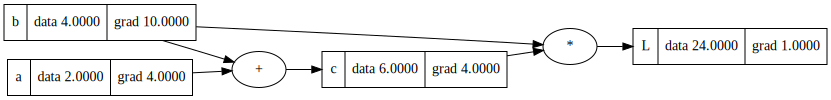

In [6]:
a = Value(2.0, label="a")
b = Value(4.0, label="b")
c = a + b ; c.label = "c"
L = c * b ; L.label = "L"
L.backward()
draw_dot(L)

In [31]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [32]:
mlp = MLP(3, [4,4,1]) # 3 input features, 2 hidden layers with 4 neurons each and 1 output neuron

In [33]:
for k in range(100):

    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yhat - ygt)**2 for ygt, yhat in zip(ys, ypred)])
    
    # backward pass / backpropagation
    for p in mlp.parameters():
        p.grad = 0.0 # remember to flush the gradients!! pyTorch .zero_grad()
    loss.backward()

    # update
    # learning_rate = 0.1 # don't set this too high or our model might overstep
    learning_rate = 0.1 - (0.09*k / 100) # learning rate decay; high at the beginning, low at the end for finer details
    for p in mlp.parameters():
        p.data += -learning_rate * p.grad

    print(k, loss.data)    


0 3.7391673220185533
1 4.263132183033043
2 3.0430776063580867
3 0.05281258335784647
4 0.04456281244845657
5 0.03880931481128216
6 0.03449508740272541
7 0.03111234002265807
8 0.028376877032482428
9 0.02611358022383757
10 0.02420717215553837
11 0.02257801101043262
12 0.021168998627514757
13 0.01993797619987054
14 0.018853056959611994
15 0.017889632781971268
16 0.017028384187557703
17 0.016253917202618654
18 0.015553805600919554
19 0.014917903100477506
20 0.014337839924921915
21 0.013806648074597899
22 0.013318478209050633
23 0.012868382865996304
24 0.012452148459961556
25 0.01206616365150189
26 0.011707315178051843
27 0.011372904659001138
28 0.01106058158947059
29 0.010768288950636194
30 0.010494218740965386
31 0.010236775373604514
32 0.009994545358991313
33 0.009766272045740595
34 0.009550834459837964
35 0.009347229485362844
36 0.0091545567858995
37 0.008972005986408817
38 0.008798845729322944
39 0.008634414292371655
40 0.008478111513898778
41 0.008329391817718622
42 0.00818775816656881

In [34]:
ypred

[Value=(0.9734365008745369),
 Value=(-0.9605212016250251),
 Value=(-0.9576804517534921),
 Value=(0.965921347460288)]

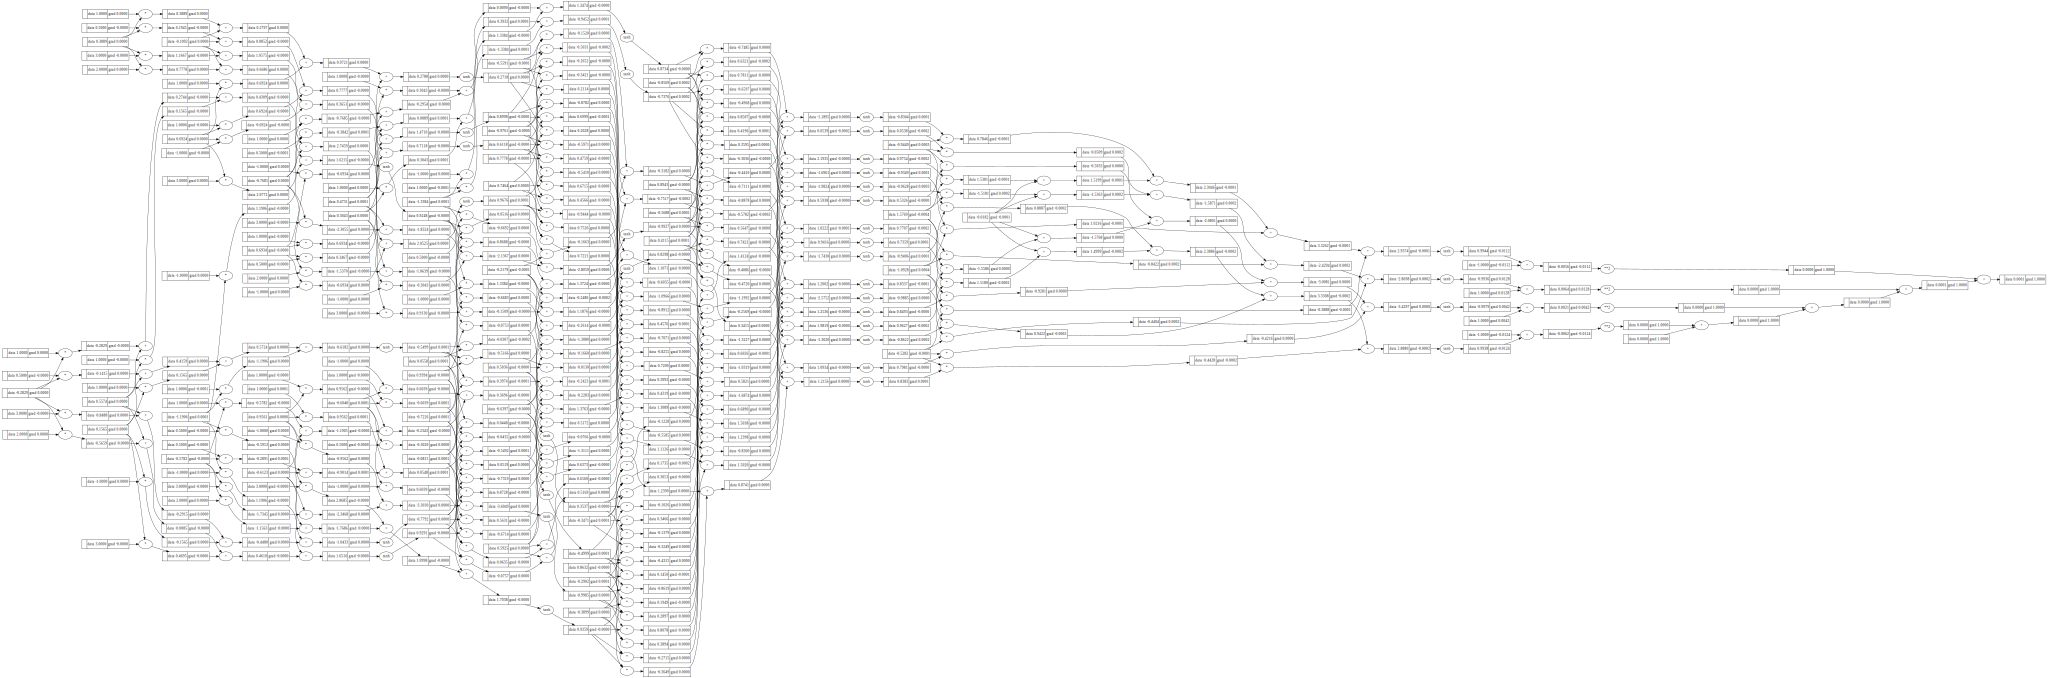

In [11]:
draw_dot(loss)